# Regression - Real Estate in Rishon Lezion

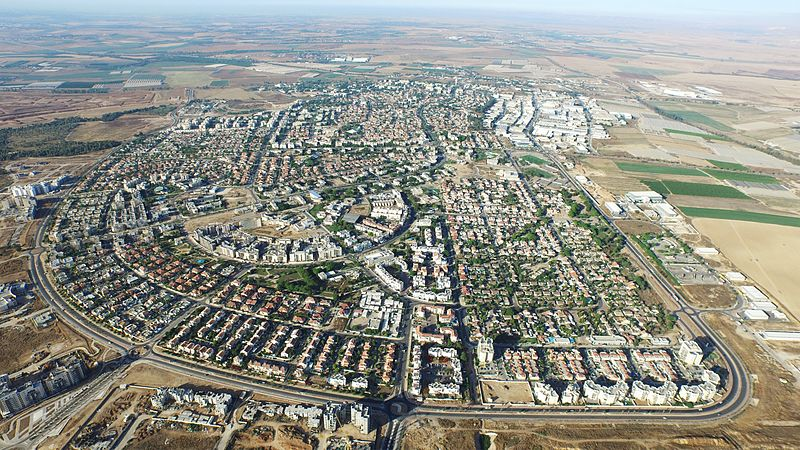

## Table of Contents
* **Main goal**.
* **Creating the DataFrame**.
* **Details explanation**.
* **Changing from text to numerical**.
* **Basic ploting**.
* **Data Exploring**.
* **Correlation matrix**.
* **Spliting the data into train and test parts**.
* **Scaling (normalization)**.
* **Train plot**.
* **Models**.
* **Conclusion**.

## Main Goal

Predict the price of an apartment according to the details it has.

This model has a lot of importance to us, because we need to buy an apartment soon or later.. and this project helped us to understand the basics of real estate.

In [1]:
# Importing the neccesary libraries
import sys
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.metrics import mean_squared_error, confusion_matrix
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings('ignore')

## Creating the Dataframe
The csv file that we created from web scraping

In [2]:
df = pd.read_csv('C:/Users/matan/Data Science Project/Rishon_Lezion_Nadlan.csv')

In [3]:
df.shape

(25837, 10)

In [4]:
df.head()

,index,Year sold,Month sold,Day sold,Street,Kind,Number of rooms,Floor,Squared meter,Price
0,0,2021,12,20,נירים,דירה בבית קומות,6.0,6.0,134.60,3670000
1,1,2021,12,19,קרל נטר,דירה בבית קומות,3.0,3.0,81.00,1770000
2,2,2021,12,16,יהודה הלוי,דירה בבית קומות,5.0,5.0,120.00,2400000
3,3,2021,12,15,שרירא שמואל,דירה בבית קומות,4.0,2.0,64.32,2050000
4,4,2021,12,15,"תרמ""ב",דירה בבית קומות,3.0,3.0,80.98,1640000


In [5]:
# removing the unnecesary columns
df.pop('index')

0            0
1            1
2            2
3            3
4            4
         ...  
25832    25832
25833    25833
25834    25834
25835    25835
25836    25836
Name: index, Length: 25837, dtype: int64

## Details explanation:

 * **Year sold**- The year the apartment has been sold.
 * **Month sold**- The month the apartment has been sold.
 * **Day sold**- The day the apartment has been sold.
 * **Street**- The apartment's street.
 * **Street Number**- The apartment's street number.
 * **Number of rooms**- Number of rooms the apartment has.
 * **Floor**- The apartment's floor level.
 * **Squared meter**- The apartment size.
 * **Price**- The apartment price when it was sold.

In [6]:
df.isnull().sum()
# We have no null values,
# That's because we already fixed it the 'Web Scraping' notebook.

Year sold          0
Month sold         0
Day sold           0
Street             0
Kind               0
Number of rooms    0
Floor              0
Squared meter      0
Price              0
dtype: int64

## Changing from text to numerical
Replace text to integers in column 'Kind' by levels

In [7]:
df["Kind"].replace({"דירה": "1", "דירה בבית קומות": "1"}, inplace=True)
df["Kind"].replace({"דירת גן": "2"}, inplace=True)
df["Kind"].replace({"דירת גג": "3", "דירת גג (פנטהאוז)": "3"}, inplace=True)
df["Kind"] = df["Kind"].astype('int64')

## Data errors
When we explored the data, we had found some typing errors.

In [8]:
df_above_50 = df.loc[df['Price'] > 50000000]

In [9]:
df_above_50

,Year sold,Month sold,Day sold,Street,Kind,Number of rooms,Floor,Squared meter,Price
7698,2017,6,11,הרב ברוק,1,2.0,1.0,42.0,106000000
13216,2014,3,3,הרב ברוק,1,2.0,1.0,60.0,72000000
18316,2011,2,18,הרב ברוק,1,2.0,3.0,42.0,67000000
18540,2010,12,28,אלקלעי,1,2.0,3.0,55.0,75000000
20292,2009,11,18,"שז""ר זלמן",1,4.0,9.0,126.0,200000000


After asking family that lives in Rishon Lezion, and by seeing by eyes the houses, we know for sure those aren't the real prices of this houses and therfore we will remove them from our data.

In [10]:
df = df.loc[df['Price'] <= 50000000]

## Basic ploting
From the hist function we can see the distribution of each column in our DataFrame.

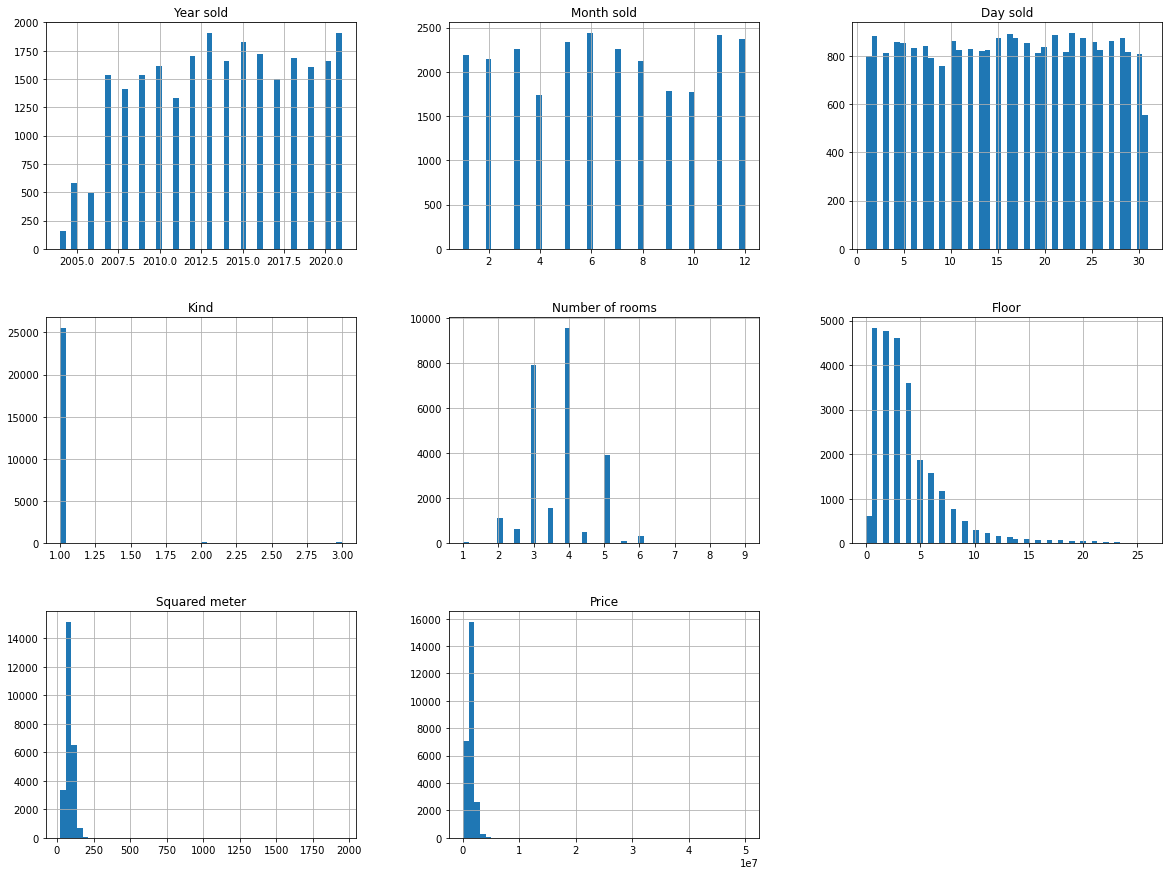

In [11]:
df.hist(bins=50, figsize=(20,15))
plt.show()

As we can see, there are outliers in our data, we understood from our practitioner that we are not allowed removing the outlier rows in here (we will perform it later on, after we will split our data to train and test parts).

## Data Exploring
Let's check which street is generally more expensive by using 'GroupBy' method on the 'Street' column.

In [12]:
streets = df.groupby(['Street']).agg({'Price':'sum','Street':'count'}).rename(columns={'Street':'num_of_apartments'})

In [13]:
streets['Average'] = streets['Price'] / streets['num_of_apartments']

In [14]:
streets.sort_values('Average', ascending = False)

,Price,num_of_apartments,Average
Street,,,
התבור,8600000,1,8.600000e+06
הסיפון,6820000,1,6.820000e+06
נחמיה,16061000,3,5.353667e+06
"אח""י משגב",9850000,2,4.925000e+06
מבצע שלמה,4880000,1,4.880000e+06
...,...,...,...
רבי עקיבא,477000,1,4.770000e+05
סטרומה,400000,1,4.000000e+05
האלה,400000,1,4.000000e+05


Note: The data has no equal number of apartments in each Street.

So basically we can't conclude from that which streets are the most elite.

Let's check which the average price each year using 'GroupBy'.

In [15]:
years = df.groupby(['Year sold']).agg({'Price':'sum','Year sold':'count'}).rename(columns={'Price':'Total price','Year sold':'num_of_apartments'})

In [16]:
years['Average'] = years['Total price'] / years['num_of_apartments']

In [17]:
years.sort_values('Average', ascending = False)

,Total price,num_of_apartments,Average
Year sold,,,
2021,3522338067,1905,1.848996e+06
2020,2901861000,1655,1.753390e+06
2019,2724015497,1605,1.697206e+06
2017,2535202311,1501,1.689009e+06
2018,2837191585,1682,1.686796e+06
2016,2760115766,1724,1.600995e+06
2015,2730485689,1826,1.495337e+06
2014,2412412318,1657,1.455892e+06
2013,2749141685,1904,1.443877e+06


As we thought, each year (except 2005 and 2006 that has less selling data, we can assume that those years has less data because they are older) is more expensive in average than the last year.

We can assume with that data that the prices will still goes up in average, means that it is worth buying an apartment in Rishon Lezion now (unless something extreme will happen).

## Correlation matrix

The correlation matrix (heatmap) is so important because from it we can see which columns are more correlated to others, And in particular, to the 'Price' column.

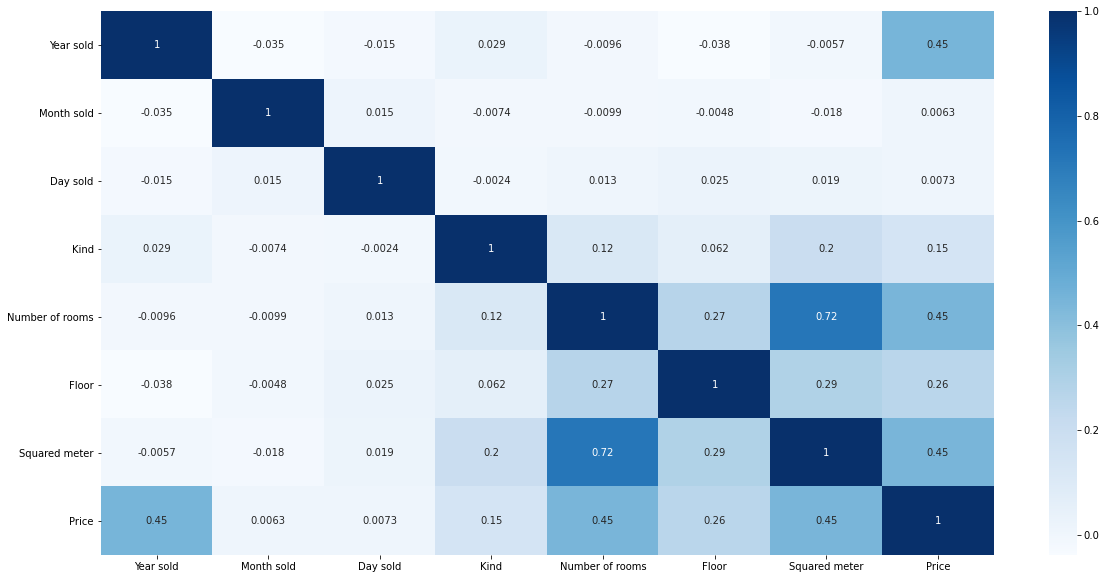

In [18]:
plt.figure(figsize=(20, 10))
sb.heatmap(df.corr(), cmap = 'Blues', annot=True);

From the heatmp we can see that the 'Month sold' and 'Day sold' columns are not correlated to the 'Price' column.

While the 'Floor' has some correlation to the 'Price', but not strong like the correlation between 'Year sold', 'Squared meter', 'Number of rooms' and 'Price'.

Note: we tried several approaches, the best of them was to 'pop' the uncorrelateed columns.

In [19]:
# deleting those columns
df.pop('Month sold')
df.pop('Day sold')

0        20
1        19
2        16
3        15
4        15
         ..
25832     8
25833     8
25834     8
25835     8
25836     7
Name: Day sold, Length: 25832, dtype: int64

Note: we checked several options (removing the steet column, giving each street a unique number, ...).

The best of them was the one with 'get_dummies' function on the 'Street' column.

In [20]:
df_with_street_dummies = pd.get_dummies(df, columns = ['Street'], prefix = '', prefix_sep = '')

In [21]:
df_with_street_dummies.head()

,Year sold,Kind,Number of rooms,Floor,Squared meter,Price,אבידן שמעון,אביחיל,אביעזר,אבן גבירול,...,שפרינצק,שרירא שמואל,שרף חיים,תדהר דוד,תורה ועבודה,תל חי,תנועות הנוער,תנחום,"תרמ""ב",תרשיש
0,2021,1,6.0,6.0,134.60,3670000,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2021,1,3.0,3.0,81.00,1770000,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2021,1,5.0,5.0,120.00,2400000,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2021,1,4.0,2.0,64.32,2050000,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
4,2021,1,3.0,3.0,80.98,1640000,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


## Spliting the data into train and test parts
The train_test_split() method splits the data according to a random state, if we'll choose some random state, than over multiple reruns, the resulting dataframes from the method remain the same (we chose random state 7).

In [22]:
prices = df_with_street_dummies['Price']
data_without_prices = df_with_street_dummies.drop(['Price'],axis=1)
X_train,X_test,y_train,y_test = train_test_split(data_without_prices, prices, test_size=0.2, random_state = 7)

In [23]:
X_train.head()

,Year sold,Kind,Number of rooms,Floor,Squared meter,אבידן שמעון,אביחיל,אביעזר,אבן גבירול,אבן חן,...,שפרינצק,שרירא שמואל,שרף חיים,תדהר דוד,תורה ועבודה,תל חי,תנועות הנוער,תנחום,"תרמ""ב",תרשיש
1928,2020,1,2.0,1.0,50.00,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5399,2018,1,3.0,2.0,65.00,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
19296,2010,1,2.0,2.0,47.88,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
15149,2013,1,5.0,1.0,112.73,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
19298,2010,1,4.0,1.0,90.24,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Cleaning outliers
First, we will remove the outliers from our data because it can make our models unstable (it did).

We will do so by uniting the train part, and split it again afterwards.

In [24]:
train = X_train.copy()

In [25]:
train['Price'] = y_train

In [26]:
train.head()

,Year sold,Kind,Number of rooms,Floor,Squared meter,אבידן שמעון,אביחיל,אביעזר,אבן גבירול,אבן חן,...,שרירא שמואל,שרף חיים,תדהר דוד,תורה ועבודה,תל חי,תנועות הנוער,תנחום,"תרמ""ב",תרשיש,Price
1928,2020,1,2.0,1.0,50.00,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1315000
5399,2018,1,3.0,2.0,65.00,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1460000
19296,2010,1,2.0,2.0,47.88,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,407000
15149,2013,1,5.0,1.0,112.73,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1719000
19298,2010,1,4.0,1.0,90.24,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1140000


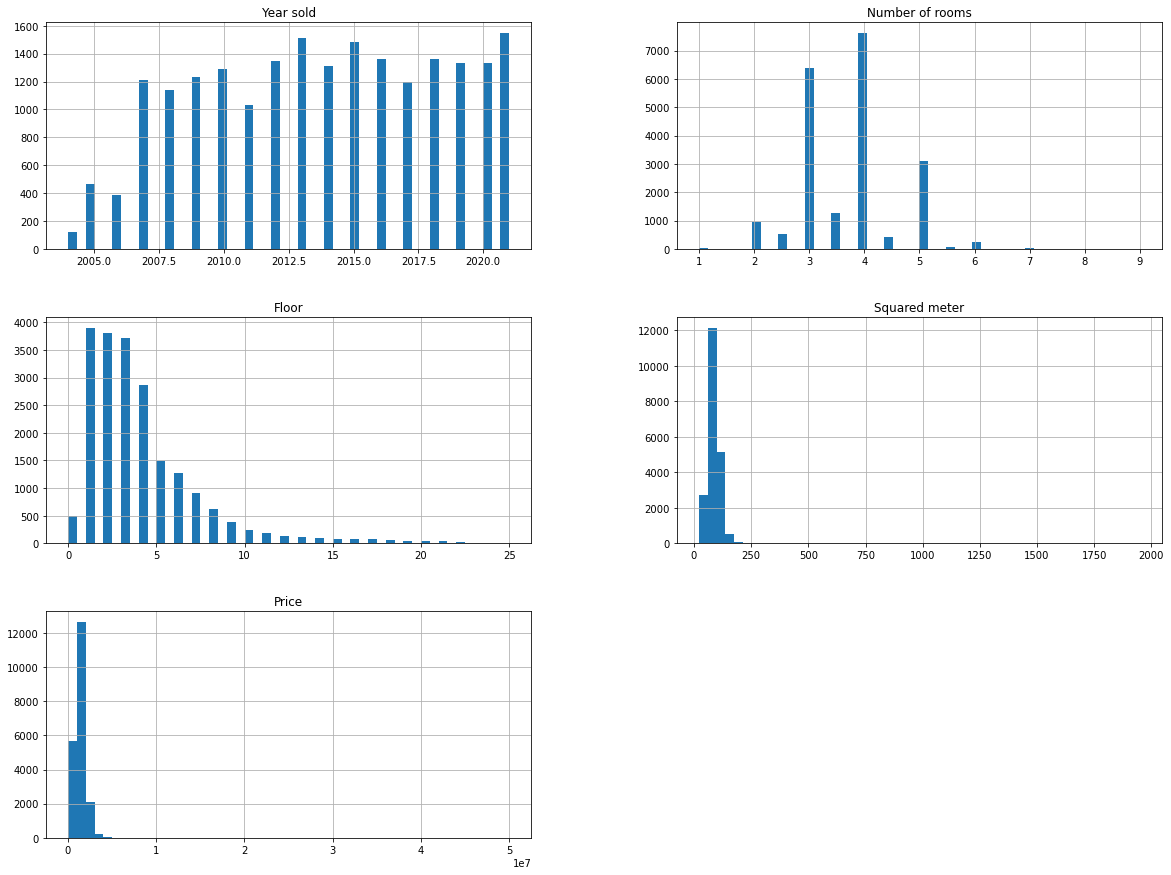

In [27]:
train.hist(column=['Year sold','Number of rooms','Floor','Squared meter','Price'], bins=50, figsize=(20,15))
plt.show()

In [28]:
train.shape

(20665, 495)

In [29]:
train = train.loc[train['Squared meter'] < 250]
train = train.loc[train['Price'] < 5000000]
# The reason we did not clean the outliers of 'Kind', it's because it will keep us only with 1 value for 'Kind' (1).
# This data didn't provide us a thing (make sense, because there is a column in the df that has only one value).
# And therefore, we preffered to remove this column.
train.pop('Kind')

1928     1
5399     1
19296    1
15149    1
19298    1
        ..
20696    1
5699     1
10743    1
16923    1
25801    1
Name: Kind, Length: 20614, dtype: int64

In [30]:
# we learned that if we are deleting a column in the train, we must delete it in the test too.
X_test.pop('Kind')

14202    1
15856    1
12539    1
9664     1
11993    1
        ..
18386    1
20585    1
9368     1
14749    1
22936    1
Name: Kind, Length: 5167, dtype: int64

In [31]:
# let's check if we didn't remove too many rows from the test
train.shape

(20614, 494)

Great, we removed only 63 rows.

Now, after we cleaned the outliers, we can continue.

In [32]:
y_train = train['Price']
X_train = train.drop(['Price'],axis=1)

In [33]:
X_train.describe()

,Year sold,Number of rooms,Floor,Squared meter,אבידן שמעון,אביחיל,אביעזר,אבן גבירול,אבן חן,אברבנאל,...,שפרינצק,שרירא שמואל,שרף חיים,תדהר דוד,תורה ועבודה,תל חי,תנועות הנוער,תנחום,"תרמ""ב",תרשיש
count,20614.000000,20614.000000,20614.000000,20614.000000,20614.000000,20614.0,20614.000000,20614.000000,20614.000000,20614.000000,...,20614.000000,20614.000000,20614.000000,20614.000000,20614.000000,20614.000000,20614.000000,20614.000000,20614.000000,20614.000000
mean,2013.821384,3.720069,3.907296,85.547094,0.000873,0.0,0.001843,0.001940,0.003832,0.009605,...,0.001504,0.010187,0.001795,0.001601,0.003687,0.005627,0.009508,0.000243,0.007616,0.000825
std,4.608236,0.850956,3.335112,25.306620,0.029538,0.0,0.042896,0.044009,0.061789,0.097536,...,0.038751,0.100419,0.042329,0.039980,0.060609,0.074805,0.097047,0.015573,0.086940,0.028706
min,2004.000000,1.000000,0.000000,21.500000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2010.000000,3.000000,2.000000,66.220000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2014.000000,4.000000,3.000000,83.100000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2018.000000,4.000000,5.000000,100.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,2021.000000,9.000000,25.000000,243.000000,1.000000,0.0,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


As we can see from above, the std for the columns: 

'Number of rooms' and 'Floor' is low - means that almost all of the data is of those columns are near the column average (make sense). 

'Year sold' is little bit higher - means that most of the data in this column are near the column average (make sense because we have more options in 'Year sold').

'Squared meter' is much more higher - means that a lot of the is not close to the column average (again, make sense because we have a tons of options for 'Squared meter').

### Train plot 

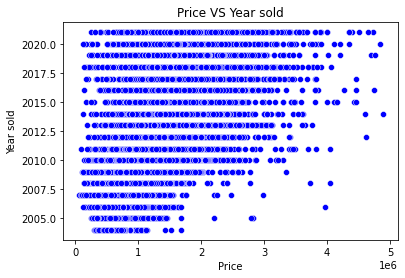

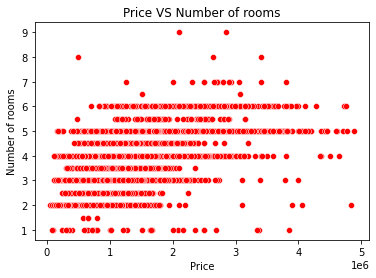

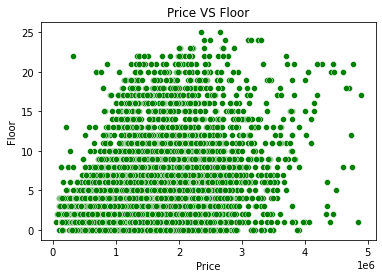

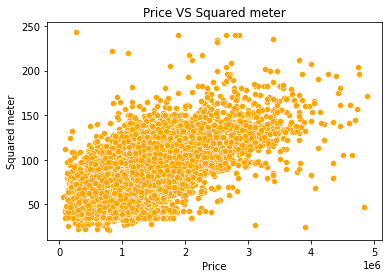

In [34]:
sb.scatterplot(x = y_train, y = X_train['Year sold'], color='blue')
plt.title("Price VS Year sold")
plt.show()

sb.scatterplot(x = y_train, y = X_train['Number of rooms'], color='red')
plt.title("Price VS Number of rooms")
plt.show()

sb.scatterplot(x = y_train, y = X_train['Floor'], color='green')
plt.title("Price VS Floor")
plt.show()

sb.scatterplot(x = y_train, y = X_train['Squared meter'], color='orange')
plt.title("Price VS Squared meter")
plt.show()

As we can see from the above, the only that directly correlated with the 'Price' column is the 'Squared meter' column.

The 'Year sold' and 'Number of rooms' columns are also correlated to the 'Price' column, but we can still see a lot of different prices in each of them.

As we saw earlier in the heatmap, the 'Year sold' column has the most correlation to the 'Price', but from basic logic and from the graphs, we can see that in each year there is a lot of apartments sold in different prices (with high gap). yet, the average per year is increasing because of the market value in out country.

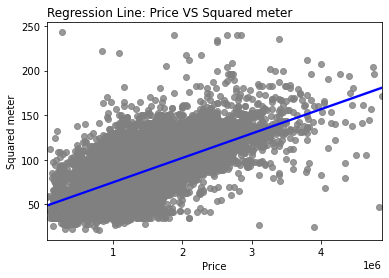

In [35]:
ax = sb.regplot(x=y_train, y=X_train["Squared meter"], fit_reg=True, scatter_kws={"color": "grey"}, line_kws={"color": "blue"})
ax.set_title("Regression Line: Price VS Squared meter", color="black", loc='left');

As we thought, we can see from the graph the 'Price' goes up while the 'Squared meter' goes up.

Splitting again the train into train and test parts, so we won't predict our models on the test itself, and by that, we will prevent Data leakage.

In [36]:
X_train_train,X_train_test,y_train_train,y_train_test = train_test_split(X_train, y_train, test_size=0.2, random_state = 7)

## Scaling
After we removed all of the NaN values and changed all of the text value to numerical data, we can scale our data.
### Normalization
Before we split the data into train and test sets, we must scale the values, we chose doing that by normalization. It's enough to normalize only the columns: 'Year sold', 'Number of rooms', 'Floor', 'Squared meter'. Because all other columns has already only 0 and 1 values.

In [37]:
cols = ['Year sold', 'Number of rooms', 'Floor', 'Squared meter']

# scaling the train and test of the original train
# we will use it to evaluate our models (without cv)
basic_scale = MinMaxScaler()
X_train_train[cols] = basic_scale.fit_transform(X_train_train[cols])
X_train_test[cols] = basic_scale.transform(X_train_test[cols])

# scaling the original train and test
# we will use it for the original train for CV, and for the best model
scale = MinMaxScaler()
X_train[cols] = scale.fit_transform(X_train[cols])
X_test[cols] = scale.transform(X_test[cols])

### Models
Before jumping into the models scores, we will present some basic definitions:
* **Mean Absolute Error (MAE)** - The mean of the absolute values of the individual prediction errors on over all instances in the test set.
* **Mean Squared Error (MSE)** - The mean of the squared values of the individual prediction errors on over all instances in the test set.
* **Root Mean Squared Error (RMSE)** - The root of the MSE.
* **r^2 score** - A measure of how close each data point fits to the regression line. In other words, it tells us how well the regression line predicts actual values.
 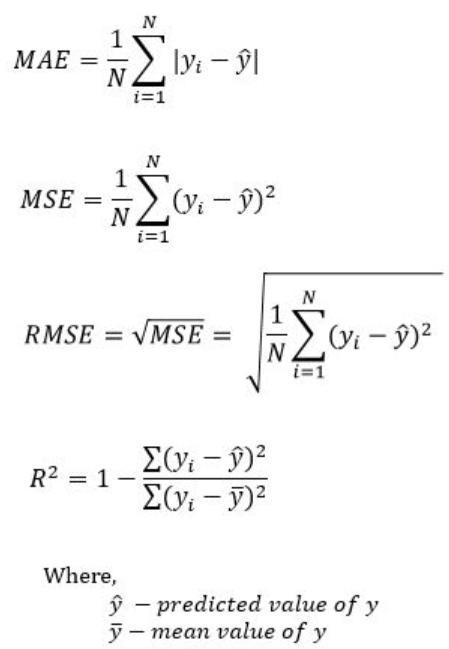

#### Dummy Regressor
The Dummy Regressor is a kind of Regressor that gives prediction based on simple strategies without paying any attention to the input Data.

##### 1) Median approach
In this approach the model will calculate the median of the training the data, and will predict always that value on new data.

In [38]:
dummy_reg_by_median = DummyRegressor(strategy="median")
dummy_reg_by_median.fit(X_train_train, y_train_train)
pred = dummy_reg_by_median.predict(X_train_test) 

print("r^2 score: ",dummy_reg_by_median.score(X_train_test, y_train_test))
print("MAE: ", metrics.mean_absolute_error(y_train_test, pred))
print ("MSE: ",mean_squared_error(y_train_test, pred))

r^2 score:  -0.004107273047038618
MAE:  430886.7938394373
MSE:  322656232612.723


In [39]:
# Cross validation
dummy_reg_by_median_scores = cross_val_score(DummyRegressor(strategy="median"), X_train, y_train, cv=10,scoring="neg_mean_squared_error")
dummy_reg_by_median_scores_r2 = cross_val_score(DummyRegressor(strategy="median"),X_train, y_train,cv=10,scoring="r2")
dummy_median_err = np.sqrt(-dummy_reg_by_median_scores.mean())

print("r^2 score: ",dummy_reg_by_median_scores_r2.mean())
print ("RMSE: ",dummy_median_err)

r^2 score:  -0.005628363037805761
RMSE:  570327.0271221381


##### 2) Mean approach
In this approach the model will calculate the mean of the training the data, and will predict always that value on new data.

In [40]:
dummy_reg_by_mean = DummyRegressor(strategy="mean")
dummy_reg_by_mean.fit(X_train_train, y_train_train)
pred = dummy_reg_by_mean.predict(X_train_test)

print("r^2 score: ",dummy_reg_by_mean.score(X_train_test, y_train_test))
print("MAE: ", metrics.mean_absolute_error(y_train_test, pred))  
print ("MSE: ",mean_squared_error(y_train_test, pred))

r^2 score:  -8.9295755340002e-05
MAE:  432795.7755360956
MSE:  321365110189.38983


In [41]:
# Cross validation
dummy_reg_by_mean_scores = cross_val_score(DummyRegressor(strategy="mean"), X_train, y_train, cv=10,scoring="neg_mean_squared_error")
dummy_reg_by_mean_scores_r2 = cross_val_score(DummyRegressor(strategy="mean"),X_train, y_train,cv=10,scoring="r2")
dummy_mean_err = np.sqrt(-dummy_reg_by_mean_scores.mean())

print("r^2 score: ",dummy_reg_by_mean_scores_r2.mean())
print ("RMSE: ",dummy_mean_err)

r^2 score:  -0.0006459070116979548
RMSE:  568913.7869501923


#### Linear Regression
This model creates a linear equation based on the data it recieved that minimizes the square of the distance between the observed values and the line.

* **Simple linear regression**:
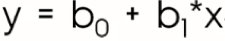

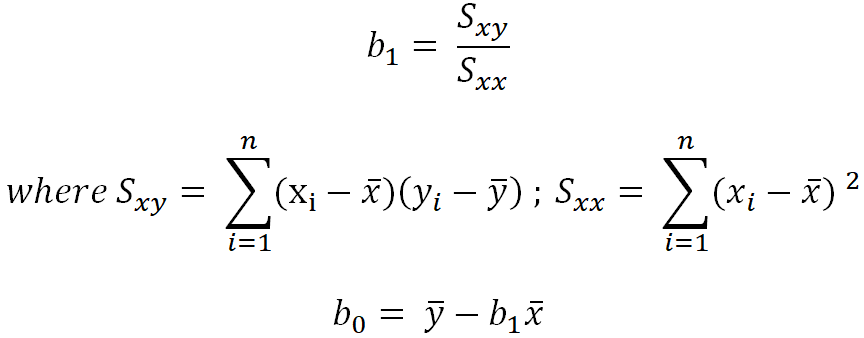

* **Multiple linear regression**:
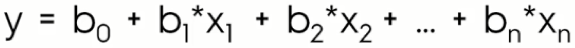

In [42]:
linear_reg = LinearRegression()
linear_reg.fit(X_train_train, y_train_train)
pred = linear_reg.predict(X_train_test)

print("r^2 score: ",linear_reg.score(X_train_test,y_train_test))
print("MAE: ",metrics.mean_absolute_error(y_train_test, pred))
print ("MSE: ",mean_squared_error(y_train_test,pred))

r^2 score:  -2.694063107752891e+23
MAE:  1.313955246934066e+16
MSE:  8.65700584092623e+34


In [43]:
# Cross validation
linear_reg_scores = cross_val_score(LinearRegression(), X_train, y_train, cv=10,scoring="neg_mean_squared_error")
linear_reg_scores_r2 = cross_val_score(LinearRegression(),X_train, y_train,cv=10,scoring="r2")
linear_reg_err = np.sqrt(-linear_reg_scores.mean())

print("r^2 score: ",linear_reg_scores_r2.mean())
print ("RMSE: ",linear_reg_err)

r^2 score:  -2.5328403954560294e+22
RMSE:  9.083999128540293e+16


As we can see, we got even worser results in the Linear Regression (compared to the Dummy Regressor), we can assume from here that our data is not linear. This tells us that the linear equation the model created has higher total error than a linear line in the mean of the price that parallels to the x axis.

Note: we assuming that the reason we got this bad result in this model is because we used the 'get_dummies' function that made a lot of street name columns.

#### KNN Regressor
KNN regression is a non-parametric method that, in an intuitive manner, approximates the association between independent variables and the continuous outcome by averaging the observations in the same neighborhood. We will find which neighborhood size (number of neighbors) gives us the best score.

In [44]:
knn_reg = KNeighborsRegressor()
knn_reg.fit(X_train_train, y_train_train)
pred = knn_reg.predict(X_train_test)

print("r^2 score: ",knn_reg.score(X_train_test,y_train_test))
print("MAE: ",metrics.mean_absolute_error(y_train_test, pred))
print ("MSE: ",mean_squared_error(y_train_test,pred))

r^2 score:  0.764219581917677
MAE:  169550.73053601745
MSE:  75764834559.39595


Finding the best 'K' using **cross validation**

In [45]:
min_error = sys.maxsize
max_score = 0
min_k = 10
for k in range(1,21):  
    knn_reg_scores = cross_val_score(KNeighborsRegressor(n_neighbors=k),X_train, y_train, cv=10, scoring="neg_mean_squared_error")
    knn_reg_scores_r2 = cross_val_score(KNeighborsRegressor(n_neighbors=k),X_train, y_train, cv=10, scoring="r2")
    knn_reg_err = np.sqrt(-knn_reg_scores.mean())
    if knn_reg_err < min_error:
        min_error = knn_reg_err
        max_score = knn_reg_scores_r2.mean()
        min_k = k

knn_reg_err = min_error
print("min k: ",min_k)
print("r^2 score: ",max_score)
print("RMSE: ",min_error)

min k:  4
r^2 score:  0.7815555172449149
RMSE:  265999.90466096945


#### Random Forest
Random forest is comprised of multiple decision trees that work together as an ensemble to produce one prediction.

A decision tree is a logical construct that resembles a flowchart and illustrates a series of if-else statements. An important purpose of using random forest is to compensate for the limitations of decision tree algorithms by mapping multiple trees and using the forest's average output.

Because we didn't learn this model during the course we will perform a detailed explanation on how it works, first we will explain the Decision Tree model because the Random Forest model uses number of Decision trees.
#### Decision Tree
Decision tree builds regression or classification models in the form of a tree structure. It breaks down a dataset into smaller and smaller subsets while at the same time an associated decision tree is incrementally developed. The final result is a tree with decision nodes and leaf nodes. In each decision node we will ask if the data is satisfies a condition, we will choose the order of conditions by caculating which one gives us the highest variance. Generally, the model evaluates the variance reduction for every possible split and select the best one.

##### Steps for creating and using (step 4) a Random Forest Regressor:
* **step 1)** - Create a 'bootstrap' dataset. To do so we will randomly select samples from the original dataset (a sample can be chosen randomly multiple times).
* **step 2)** - Create a decision tree using the bootsrapped dataset, but only use a random subset of features (columns) at each step.
* **step 3)** - Do the first 2 steps a lot of times (by that, we will create a variety of decision trees).
* **step 4)** - To predict the data, we will go over all the trees we have with the data of the test sample, and the result will be the average of them.

In [46]:
# random_state controls both the randomness of the bootstrapping of the samples used when building trees (if bootstrap=True),
# and the sampling of the features to consider when looking for the best split at each node.
rf_reg = RandomForestRegressor(random_state=7)
rf_reg.fit(X_train_train, y_train_train)
pred = rf_reg.predict(X_train_test) 

print("r^2 score: ",rf_reg.score(X_train_test,y_train_test))
print("MAE: ",metrics.mean_absolute_error(y_train_test, pred))
print ("MSE: ",mean_squared_error(y_train_test,pred))

r^2 score:  0.800586227918482
MAE:  156434.82515561933
MSE:  64078906863.86915


In [47]:
# Cross validation
rf_reg_scores = cross_val_score(RandomForestRegressor(random_state=7),X_train, y_train, cv=10, scoring="neg_mean_squared_error")
rf_reg_scores_r2 = cross_val_score(RandomForestRegressor(random_state=7),X_train, y_train, cv=10, scoring="r2")
rf_reg_err = np.sqrt(-rf_reg_scores.mean())

print("r^2 Score: ",rf_reg_scores_r2.mean())
print ("RMSE: ",rf_reg_err)

r^2 Score:  0.8101069113340944
RMSE:  248071.15394808876


## HyperParameters Tuning

For improvment, we will use GridSearchCV on our best model.

The GridSearchCV chooses parameters between all of the possible combinations we have given in 'param_grid'.

Evantually, we can see which parameters combination gives us the best score.

In [48]:
# number of trees in the random forest.
n_estimators_list = [100, 500, 1000, 3000]
# maximum number of features to consider at every split,
# round(max_features * n_features) features are considered at each split.
max_features_list = np.arange(0.01,0.2,0.01)
# for each tree, N samples are drawn randomly with replacement from the training set (bootstrap)
# and the tree is built on this new version of the training data.
max_samples_list = [0.5,0.75,1.0]
params = {'n_estimators':n_estimators_list,
          'max_features':max_features_list,
          'max_samples':max_samples_list}
grid_model = GridSearchCV(estimator = RandomForestRegressor(random_state=7),
                              param_grid = params,
                              n_jobs = -1,
                              cv = 10)
#  n_jobs = -1 means using all processors

In [49]:
# fitting the training part
grid_model.fit(X_train, y_train);

In [50]:
# The best parameters
best_parameters = grid_model.best_params_
print(best_parameters)

{'max_features': 0.04, 'max_samples': 0.75, 'n_estimators': 3000}


In [51]:
# The best score we recieved on our train part.
best_score = grid_model.best_score_
print("r score: ",best_score)

r score:  0.8343787131666286


#### Predicting the test itself

In [52]:
best_rf = RandomForestRegressor(random_state=7, max_features= 0.04, max_samples= 0.75, n_estimators= 3000)
best_rf.fit(X_train, y_train)
pred = best_rf.predict(X_test)
best_rf_err = mean_squared_error(y_test,pred)

print("r^2 score: ",best_rf.score(X_test,y_test))
print("MAE: ",metrics.mean_absolute_error(y_test, pred))
print ("MSE: ",best_rf_err)

r^2 score:  0.7504379214969394
MAE:  146698.857420868
MSE:  99623722416.3128


# Conclusion

## Models score 

In [53]:
print("Dummy Regressor (by median): ",dummy_median_err," RMSE")
print("Dummy Regressor (by mean): ",dummy_mean_err," RMSE")
print("Linear Regression: ",linear_reg_err," RMSE")
print("KNN Regressor: ",knn_reg_err," RMSE")
print("Random Forest Regressor: ",rf_reg_err," RMSE")

Dummy Regressor (by median):  570327.0271221381  RMSE
Dummy Regressor (by mean):  568913.7869501923  RMSE
Linear Regression:  9.083999128540293e+16  RMSE
KNN Regressor:  265999.90466096945  RMSE
Random Forest Regressor:  248071.15394808876  RMSE


The best model (between the models that we checked) for our dataset is: **Random Forest Reggresor**

After a GridSearchCV we improved it and got the best HyperParameters.

Our test score is: **0.75043**.